In [1]:
%load_ext autoreload
%autoreload 2

In [92]:
import torch
import torch.nn as nn
from tqdm import tqdm
from lib.data.datasets import AccRawDataset
from lib.data.dataloading import load_raw
from lib.config import RAW_DIR
from lib.modules import optimization_loop_xonly
from lib.models import MAEAlpha, MAEBeta, MAEGamma

In [3]:
WINSIZE = 1001
trainloader, testloader = load_raw(
    RAW_DIR,
    WINSIZE,
    n_hours=1,
    # sessions=['2023-11-02_13_55_22'],
    test_size=0.5,
    batch_size=256,
    shuffle_test=True,
    chunk_len_hrs=0.25
)

Using all available sessions
Using Directories: ['11-07_20_24_32', '2023-10-26_15_32_20', '11-07_17_43_30', '11-08_08_27_30', '11-08_07_17_47', '11-10_08_54_24', '2023-11-11_17_50_20', '2023-11-01_15_47_52', '2023-11-01_15_49_48', '11-07_12_58_43', '2023-11-10_13_11_41', '2023-11-02_13_55_22', '11-01_20_34_28', '10-27_00_21_25', '11-07_17_29_01', '11-01_20_54_52', '11-07_15_03_24', '10-27_09_45_42', '11-02_19_28_19', '10-28_13_18_42', '10-27_00_20_15']
Index: 0, Date: 11-07_20_24_32, nSamples: 30117, Time Elapsed: 0:04:49.392967, Time Recorded: 0:05:01.170000
Index: 1, Date: 2023-10-26_15_32_20, nSamples: 2961601, Time Elapsed: 7:53:59.529118, Time Recorded: 8:13:36.010000
Index: 2, Date: 11-07_17_43_30, nSamples: 1005447, Time Elapsed: 2:41:00.547341, Time Recorded: 2:47:34.470000
Index: 3, Date: 11-08_08_27_30, nSamples: 5125043, Time Elapsed: 1 day, 6:08:45.212074, Time Recorded: 14:14:10.430000
Index: 4, Date: 11-08_07_17_47, nSamples: 338215, Time Elapsed: 0:54:09.386096, Time Rec

In [111]:
DEVICE = 'cuda:1'
model = MAEGamma(WINSIZE, 3).to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)

In [112]:
optimization_loop_xonly(
    model,
    trainloader,
    testloader,
    criterion,
    optimizer,
    epochs=20,
    device=DEVICE,
    outdir='dev/7_mae/dev9_gamma_do'
)

  0%|          | 0/20 [00:00<?, ?it/s]

: Epoch 5: Train Loss: 2.1003: Dev Loss: 6.545:  30%|███       | 6/20 [40:59<1:35:39, 409.95s/it] 


KeyboardInterrupt: 

In [5]:
model.load_state_dict(torch.load('dev/7_mae/beta/best_model.pt'))

<All keys matched successfully>

In [36]:
import plotly.express as px
import pandas as pd

embedding = []
Xs = []
for X in trainloader:
    x = X.view(-1, 3, WINSIZE).to(DEVICE)
    x = model.e(x)
    mask = torch.rand(x.shape[0], 1, x.shape[2]) < 0.75 # maskpct% of values are True
    mask = mask.expand(-1, model.enc_dims[-1],-1)                         # expand to all 64 dims
    x_masked = x.clone()
    x_masked[mask] = torch.randn(x.shape)[mask].to(x.device)
    x = model.r(x_masked)
    logits = model.d(x).flatten(start_dim=1).detach().cpu()
    break

In [48]:
i = 8
df = pd.DataFrame({
    'x': X[i,:1001], 
    'y': X[i,1001:2002], 
    'z': X[i,2002:], 
    'x_pred': logits[i,:1001], 
    'y_pred': logits[i,1001:2002], 
    'z_pred': logits[i,2002:],
})
fig = px.line(df, x=df.index, y=['x', 'x_pred', 'y', 'y_pred', 'z', 'z_pred'])
fig.show(renderer='browser')

In [8]:
import matplotlib.pyplot as plt

embedding = []
Xs = []
for i,X in enumerate(tqdm(trainloader)):
    with torch.no_grad():
        Xs.append(X)
        X = X.view(-1, 3, WINSIZE)
        X = X.to(DEVICE)
        logits = model.e(X).detach().cpu()
        embedding.append(logits.mean(dim=2))
    
    if i == 500:
        break

embedding = torch.cat(embedding, dim=0)
Xs = torch.cat(Xs, dim=0)

  0%|          | 0/708 [00:00<?, ?it/s]

 71%|███████   | 500/708 [00:18<00:07, 27.35it/s]


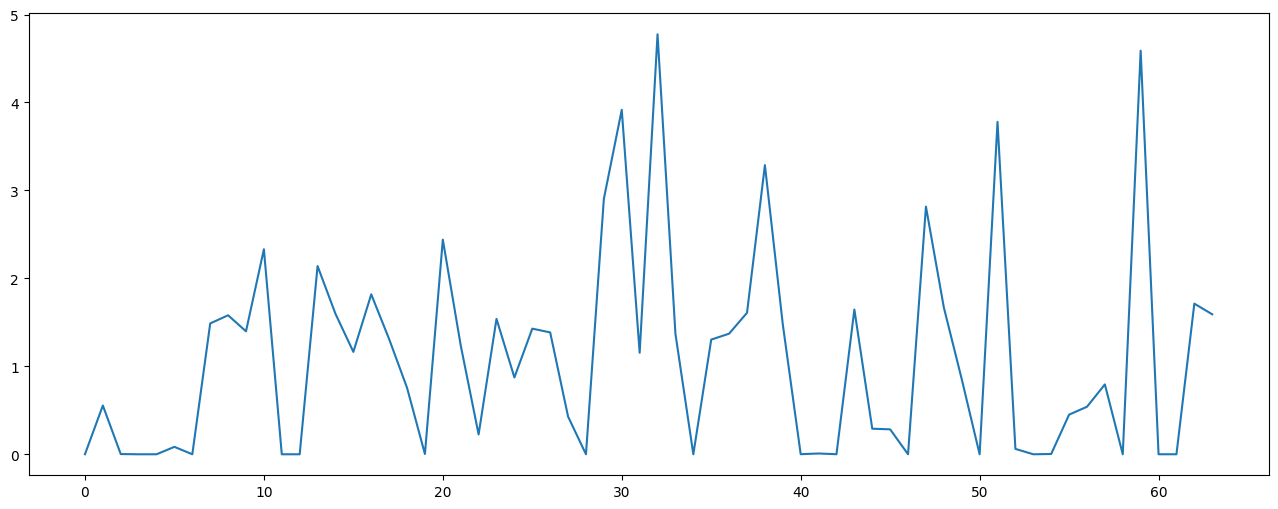

In [14]:
plt.figure(figsize=(16, 6))
plt.plot(embedding[0])
plt.show()

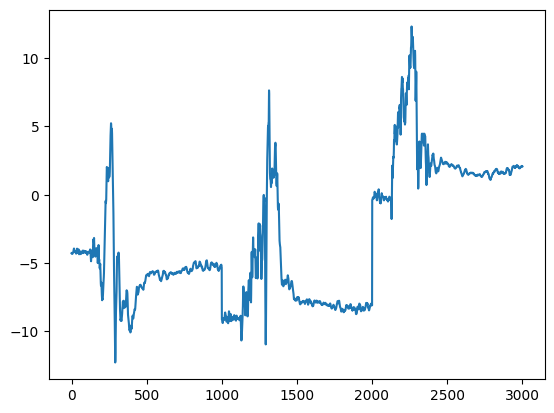

In [19]:
plt.plot(Xs[0])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

Xs_np = Xs.numpy()

# Cluster each sample (3003 dims) into one of 4 clusters
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters)
cluster_labels = kmeans.fit_predict(Xs_np)
print(f'WSS: {kmeans.inertia_}')

# Apply PCA for dimensionality reduction to 2 components
pca = PCA(n_components=2)
data_pca = pca.fit_transform(Xs_np)
print(f'Var explained: {pca.explained_variance_ratio_}')
print(f'Total variance captured: {sum(pca.explained_variance_ratio_)}')

# Visualize the reduced data using a scatter plot
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.title('PCA Visualization of Accelerometer Data with 4 clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

emb_np = embedding.numpy()

# Cluster each sample (1001 dims) into one of 4 clusters
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters)
cluster_labels = kmeans.fit_predict(emb_np)

# Apply PCA for dimensionality reduction to 2 components
pca = PCA(n_components=2)
data_pca = pca.fit_transform(emb_np)

# Visualize the reduced data using a scatter plot
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.title('PCA Visualization of MAE embedding with 4 clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


/home/musa/eating/eating-detection/env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


WSS: 930080.875
Var explained: [0.61170515 0.22859457 0.10324504 0.02077318]
Total variance captured: 0.9643179371467591


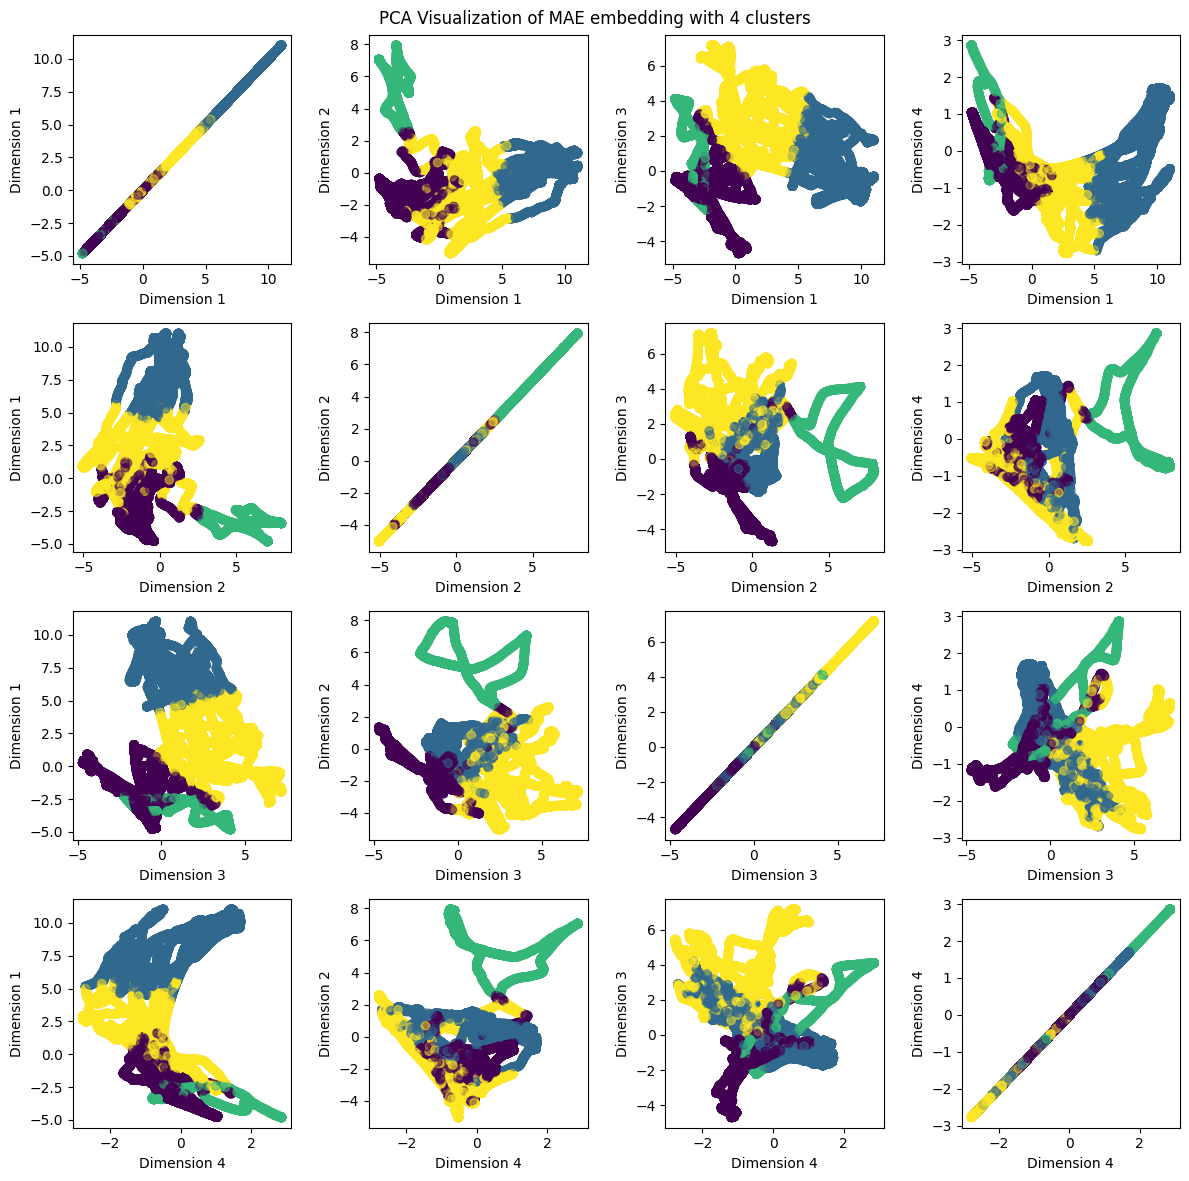

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

emb_np = embedding.numpy()

# Cluster each sample (1001 dims) into one of 4 clusters
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters)
cluster_labels = kmeans.fit_predict(emb_np)

print(f'WSS: {kmeans.inertia_}')

# four components
n_comp = 4
pca = PCA(n_components=n_comp)
data_pca = pca.fit_transform(embedding)

print(f'Var explained: {pca.explained_variance_ratio_}')
print(f'Total variance captured: {sum(pca.explained_variance_ratio_)}')

fig, axs = plt.subplots(n_comp, n_comp, figsize=(12, 12))
fig.suptitle('PCA Visualization of MAE embedding with 4 clusters')

for i in range(n_comp):
    for j in range(n_comp):
        axs[i, j].scatter(data_pca[:, i], data_pca[:, j], alpha=0.5, c=cluster_labels, cmap='viridis')
        axs[i, j].set_xlabel(f'Dimension {i + 1}')
        axs[i, j].set_ylabel(f'Dimension {j + 1}')

plt.tight_layout()
plt.show()

/home/musa/eating/eating-detection/env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


WSS: 1480646272.0
Var explained: [0.48605069 0.35383323 0.05143713 0.01289696]
Total variance captured: 0.904217994467789


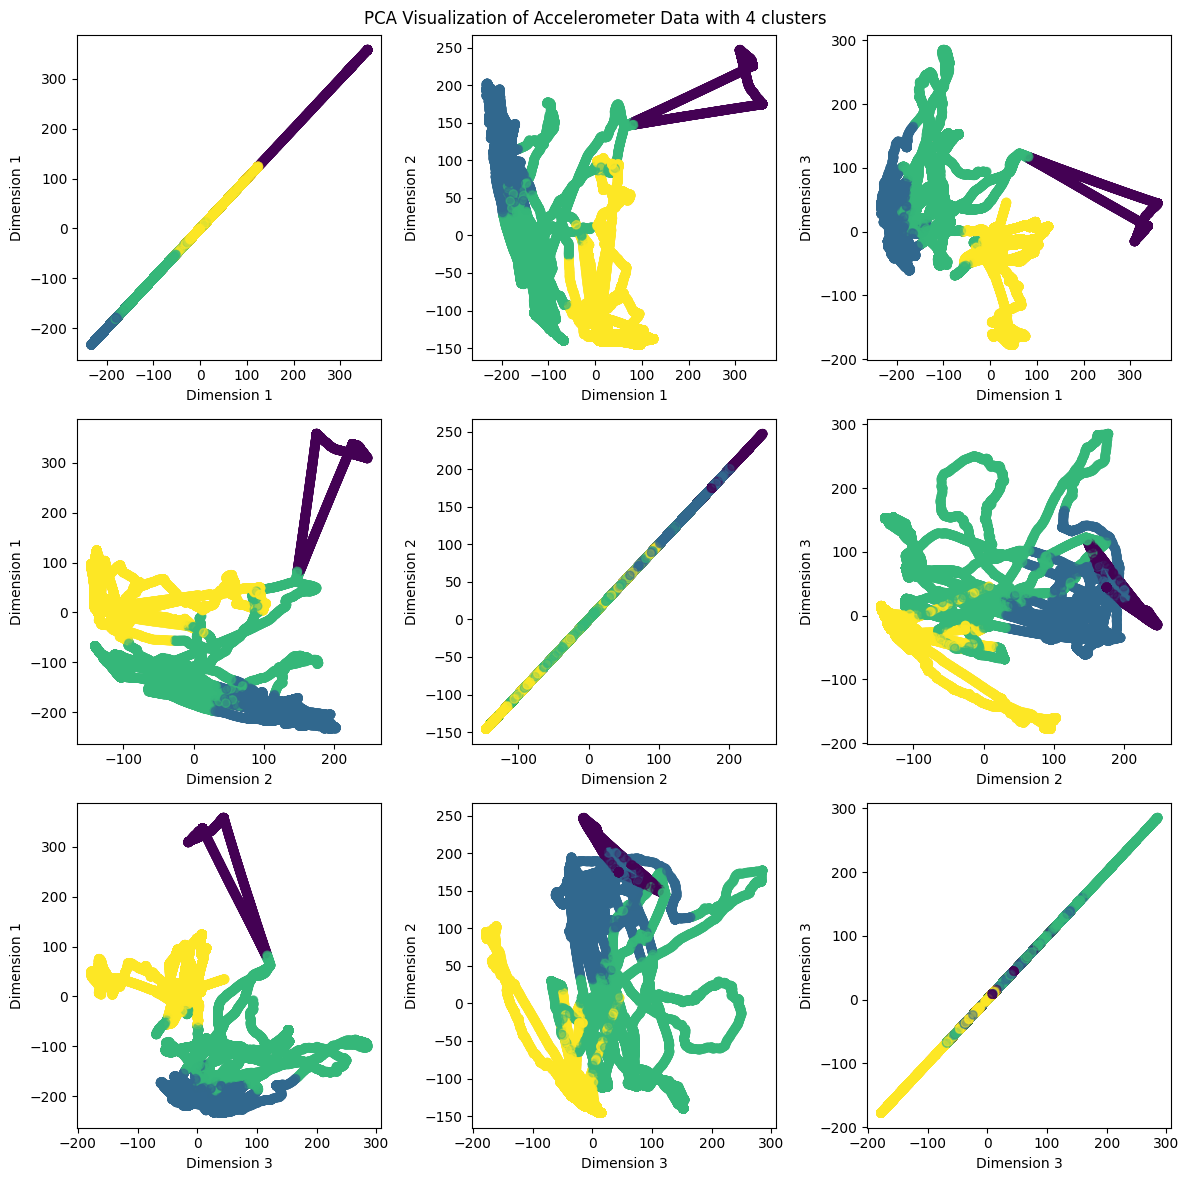

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

Xs_np = Xs.numpy()

# Cluster each sample (3003 dims) into one of 4 clusters
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters)
cluster_labels = kmeans.fit_predict(Xs_np)
print(f'WSS: {kmeans.inertia_}')

# Apply PCA for dimensionality reduction to 2 components
pca = PCA(n_components=4)
data_pca = pca.fit_transform(Xs_np)
print(f'Var explained: {pca.explained_variance_ratio_}')
print(f'Total variance captured: {sum(pca.explained_variance_ratio_)}')

fig, axs = plt.subplots(n_comp, n_comp, figsize=(12, 12))
fig.suptitle('PCA Visualization of Accelerometer Data with 4 clusters')

for i in range(n_comp):
    for j in range(n_comp):
        axs[i, j].scatter(data_pca[:, i], data_pca[:, j], alpha=0.5, c=cluster_labels, cmap='viridis')
        axs[i, j].set_xlabel(f'Dimension {i + 1}')
        axs[i, j].set_ylabel(f'Dimension {j + 1}')

fig.tight_layout()
plt.show()


In [ ]:
fig, axs = plt.subplots(1,3, figsize=(12, 12))
fig.suptitle('PCA Visualization of MAE embedding with 4 clusters')
axs[0].scatter(data_pca[:, 0], data_pca[:, 1], alpha=0.5, c=cluster_labels, cmap='viridis')
axs[0].set_xlabel(f'Dimension {1}')
axs[0].set_ylabel(f'Dimension {2}')

axs[1].scatter(data_pca[:, 0], data_pca[:, 2], alpha=0.5, c=cluster_labels, cmap='viridis')
axs[1].set_xlabel(f'Dimension {1}')
axs[1].set_ylabel(f'Dimension {3}')

axs[2].scatter(data_pca[:, 1], data_pca[:, 2], alpha=0.5, c=cluster_labels, cmap='viridis')
axs[2].set_xlabel(f'Dimension {2}')
axs[2].set_ylabel(f'Dimension {3}')

plt.tight_layout()
plt.show()